# In this notebook we want to predict the July18 patterned electrode impedance.

## We consider an equivalent circuit model composed of: an ohmic resistance in series with two parallel branches. One branch, (A) represents processes occuring through/at the mask layer. The other branch (B) represents processes through the gate and extending into the thin film LSC. Branch (B) is a series resistance attributed to current constriction near the gate followed by two parallel branches, one for the R//C behvaior of LSC material at the gate and the other for gerischer behavior extending laterally away from the gate.

## Components of the model are sourced from
1. $R_{\Omega}$: series ohmic resistanc estimated from GDC-10 ionic conductivity and macroscopic sample geometry
2. Branch (A): NoHole sample impedance measurements scaled to patterned electrode geometry
3. Branch (B), $R_c$: series resistance estimated by solving Laplacian in cylindrical coordinates, where we assume the gate is a cylinder of diameter G (gate width) aligned longitudnally with gate length. The gate-cylinder boundary is grounded and a potential is defined at a radius, r2. 
4. Branch (B), $Z_G$: 1-dimensional model of impedance from the Gerischer process extending away from the gate
5. Branch (B), $R_{gate}$: kinetially-limited resistance of LSC film at the gate, estimated by eq. 3.20 of Keita Mizuno's master's thesis, using Adler and McDonald Mixed-Bulk thermodynamic model for ${x_v}^o$, and ${R_O}^o$ extracted from FR-XAS profiles
6. Branch (B), $C_{gate}$: chemical capacitance of LSC film at the gate, estimated by eq. 3.47 of Keita Mizuno's master's thesis, using aforementioned thermo model, Vm = 33.7 $\frac{cm^3}{mol}$, and $c_{fit}=228\frac{kJ}{mol}$ (Table 3-1)

## The circuit we're considering is represented as $Z = R_{\Omega} + \frac{1}{\frac{1}{Z_{NH} x T} + \frac{1}{R_{c}+\frac{1}{\frac{1}{Z_G}+\frac{R_{gate}}{1+j \omega R_{gate} C_{gate}}}}}$

In [1]:
import glob
import sys
from IPython.display import display

import numpy as np
import pandas as pd
from scipy import signal
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager

sys.path.insert(0, '../../../impedance.py')
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist, plot_bode, plot_residuals
from impedance import preprocessing
from impedance.models.circuits.elements import G

sys.path.insert(0, '..')
import analyze_comsol as an_com
import ImpedanceCorrection as ic
import berthier_20210303 as berthier

%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.getcwd()

'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\frXAS Paper Figures'

### Read in patterned electrode data

In [22]:
data_dir = '..\EIS Data'
file_str1 = r'\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par'
file_str10 = r'\LSC_DPB1_FRXAS_700C_10%_EIS_OCV_after.par'
file_str100 = r'\LSC_DPB1_FRXAS_700C_100%_EIS_OCV_before2.par'

f_1, Z_1 = berthier.read_EIS_data(data_dir, file_str1, z_format=preprocessing.readVersaStudio)
f_10, Z_10 = berthier.read_EIS_data(data_dir, file_str10, z_format=preprocessing.readVersaStudio)
f_100, Z_100 = berthier.read_EIS_data(data_dir, file_str100, z_format=preprocessing.readVersaStudio)


# L0 = 1e-1
# Z_1 = ic.subtract_series_L(f_1, Z_1, L0)
# Z_10 = ic.subtract_series_L(f_10, Z_10, L0)
# Z_100 = ic.subtract_series_L(f_100, Z_100, L0)

print(f_1[19], f_1[-1])
print(f_10[20], f_10[-1])
print(f_100[19], f_100[-1])

fs_list = [f_1, f_10, f_100]
Zs_list = [Z_1, Z_10, Z_100]

464.1589 0.02154435
794.3282 0.007943282
359.3814 0.1


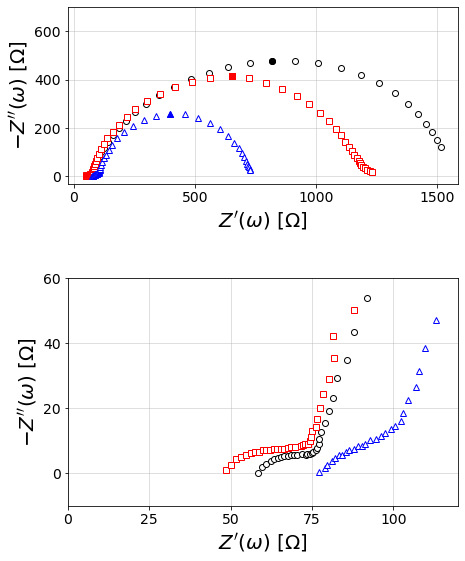

In [4]:
_, axes = plt.subplots(nrows=2, figsize=(7,10))
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1)]
markers = ['o', 's', '^']

for i, (f, Z) in enumerate(zip(fs_list, Zs_list)):
    f_peak, Z_peak = ic.find_peak_f_Z(f, Z)
    for ax in axes:
        plot_nyquist(ax, Z, c=colors[i], fmt=markers[i], mfc=(1,1,1))
        plot_nyquist(ax, Z_peak, c=colors[i], fmt=markers[i], units='\Omega')

axes[0].set_ylim(-30, 700)
axes[1].set_xlim(0, 120)
axes[1].set_ylim(-10, 60)
plt.show()

In [5]:
for Z in Zs_list:
    print(Z[0].real)

58.32154
48.67418
77.18876


## Read in NoHole sample data, truncated to the same frequency range as the patterned electrode measurements

In [6]:
data_dir = '..\EIS Data'
file_str1 = r'\NoHoleAl2O3_July18_freq_range_1%O2.csv'
file_str10 = r'\NoHoleAl2O3_July18_freq_range_10%O2.csv'
file_str100 = r'\NoHoleAl2O3_July18_freq_range_100%O2.csv'

f_1nh, Z_1nh = berthier.read_EIS_data(data_dir, file_str1, z_format=preprocessing.readCSV)
f_10nh, Z_10nh = berthier.read_EIS_data(data_dir, file_str10, z_format=preprocessing.readCSV)
f_100nh, Z_100nh = berthier.read_EIS_data(data_dir, file_str100, z_format=preprocessing.readCSV)

fs_nh_list = [f_1nh, f_10nh, f_100nh]
Zs_nh_list = [Z_1nh, Z_10nh, Z_100nh]

### Defining functions to calculate volume specific capacitance and area specific resistance for predictions down below

In [7]:
MB_delta = np.genfromtxt(r'G:\\My Drive\\UW Research\\fr-XAS July 2018\\Discussions\\Mixed_Bulk_Nonstoich.csv', delimiter=',')
MB_Ao = np.genfromtxt(r'G:\\My Drive\\UW Research\\fr-XAS July 2018\\Discussions\\Mixed_Bulk_Thermo.csv', delimiter=',')

MB_delta = MB_delta[np.argsort(MB_delta[:,0])]
MB_Ao = MB_Ao[np.argsort(MB_Ao[:,0])]

### Use Values interpolated for Ao since it's a larger data set

In [8]:
# Constructing lists of Po2, Ao, delta for both models using data arrays and 
# interpolating for Ao if Po2's don't match exactly
MB_vals = []
for delta in MB_delta:
    try:
        ao = MB_Ao[np.argwhere(np.isclose(MB_Ao[:,0], delta[0]))[0,0]][-1]
#         print(f'Match Po2: {ao[0]:.2f}, Ao: {ao[1]:.3f}, delta: {delta:.4f}')
        MB_vals.append([delta[0], ao, delta[1]])
    except IndexError:
        ao = np.interp(delta[0], MB_Ao[:,0], MB_Ao[:,1])
#         print(f'Interp Po2: {ao[0]:.2f}, Ao: {ao[1]:.3f}, delta: {delta:.4f}')
        MB_vals.append([delta[0], ao, delta[1]])

mb_df = pd.DataFrame(data=np.array(MB_vals), columns=['pO2', 'ao', 'delta'])

In [21]:
# Some geometry calculations
w = 1.04345
A_NH = np.pi * (0.65**2)
L_NH = 450e-7
A_gate = w * 4.478e-4
A_patt = .35**2 - A_gate #0.110 - A_gate  #0.117
L_LSC = 630e-7
L_patt = 280e-7
A_ratio = A_NH / A_patt

sig_i_lt = 0.0544
R_ohm = 1 / sig_i_lt * .2 / A_patt
print(R_ohm)
# Correction factor for patterned geometry to NH geometry
geom_corr = A_NH/A_patt*L_patt/L_NH

params_df = pd.DataFrame(data=[-2, -1, 0], columns=['pO2'])
params_df['ao'] = [mb_df.loc[
    np.isclose(mb_df.pO2, pO2, atol=.001), 'ao'].values[0] for pO2 in params_df.pO2.values]
params_df['xvo'] = [mb_df.loc[
    np.isclose(mb_df.pO2, pO2, atol=.001), 'delta'].values[0] / 3 for pO2 in params_df.pO2.values]

params_df['ld'] = [32.801e-4, 17.146e-4, 4.978e-4]
params_df['tg'] = [2.344, 0.9462, 0.1447]

params_df['c_chem'] = berthier.c_chem(params_df.xvo * 3)
params_df['ASR'] = berthier.ASR(params_df.ao, params_df.xvo, params_df.tg)

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) for _, row in params_df.iterrows()]
params_df['R_gate'] = params_df.ASR / A_gate
params_df['C_gate'] = params_df.c_chem * A_gate * L_LSC

# Estimated current constriction resistance
G = 4.28
r2 = 20 * G
R_con = np.log(2 * r2 / G) / sig_i_lt
R_con

30.126919178763952


67.81028408297678

In [10]:
dum = [[A_patt, A_NH, A_gate, L_patt, L_NH, L_LSC, w]]
pd.DataFrame(data=np.array(dum), columns=['A_patt', 'A_NH', 'A_gate', 'L_patt', 'L_NH', 'L_LSC', 'W'])

,A_patt,A_NH,A_gate,L_patt,L_NH,L_LSC,W
0,0.122033,1.327323,0.000467,0.000028,0.000045,0.000063,1.04345


## $T = \frac{l_{pattern}}{l_{NoHole}}\frac{A_{NoHole}}{A_{pattern}} = 9.77$

# $R_c = \frac{Ln(\frac{2r}{G})}{{\sigma_i}^{lt}}$

# $R_{\Omega} =\frac{1}{{\sigma_i}^{lt}}\frac{1 \, mm}{A_{patt}} = 15 \, {\Omega}$

No handles with labels found to put in legend.


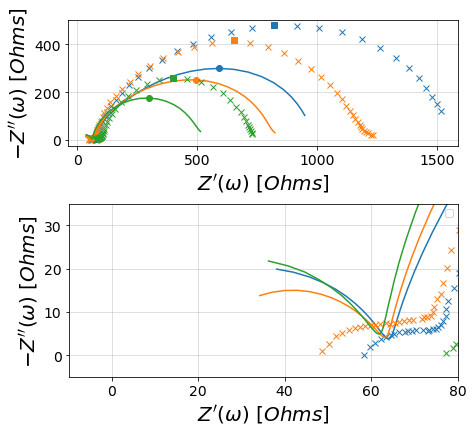

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.215444
1,-1.0,1.258925,0.501187
2,0.0,4.641589,2.782559


In [11]:
# Using estimated geometry correction factor
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

Zs_branch_b = []
f_peaks, f_peaks_model = [], []
params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) for _, row in params_df.iterrows()]

for gas, Z_nh  in enumerate(Zs_nh_list):
    Z_branch_b = berthier.predict_branchB(params_df, gas, R_con, fs_nh_list[gas])
    Zs_branch_b.append(Z_branch_b)
    
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, geom_corr)
    Z_meas = Zs_list[gas] #Zs_list[gas][0].real
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
#     print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x') #, label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='') #, label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        

axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
axes[1].legend()
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

Fit geometry factor 58.05219726562511
Fit geometry factor 23.10395507812504
Fit geometry factor 28.342822265625053


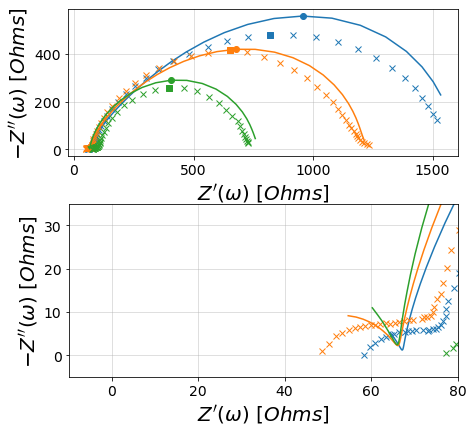

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.129155
1,-1.0,1.258925,0.398107
2,0.0,4.641589,2.154435


In [12]:
# Fitting geometry factor to datasets individually
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    
    Z_meas = Zs_list[gas]# - R_ohm
    fit = minimize(berthier.minimize_geom_factor, [6], method='Nelder-Mead',
                   args=(Z_meas, Z_branch_b, Z_nh))
    print(f'Fit geometry factor {fit.x[0]}')
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, fit.x[0])
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    
#     print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')
    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

Fit geometry factor  final_simplex: (array([[25.04919434],
       [25.04912109]]), array([53.80747219, 53.80747224]))
           fun: 53.807472188437416
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 27
        status: 0
       success: True
             x: array([25.04919434])


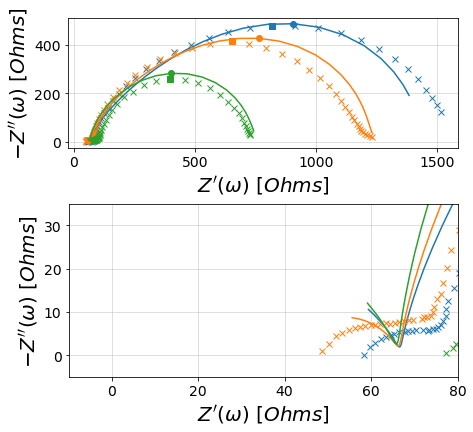

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.129155
1,-1.0,1.258925,0.316228
2,0.0,4.641589,2.154435


In [13]:
# Fitting geometry factor to all datasets simultaneously
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

fit = minimize(berthier.minimize_geom_factor_all, [6], method='Nelder-Mead',
               args=(Zs_list, Zs_branch_b, Zs_nh_list))
print(f'Fit geometry factor {fit}')

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    Z_meas = Zs_list[gas]# - R_ohm
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, fit.x[0])
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
#     print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

Fit geometry factor  final_simplex: (array([[9.76875   ],
       [9.76867676]]), array([47.27823156, 47.27823237]))
           fun: 47.27823155539929
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([9.76875])
Data peak f: 0.4641589, Model peak f: 0.2782559
Data peak f: 1.258925, Model peak f: 0.6309574
Data peak f: 4.641589, Model peak f: 2.782559


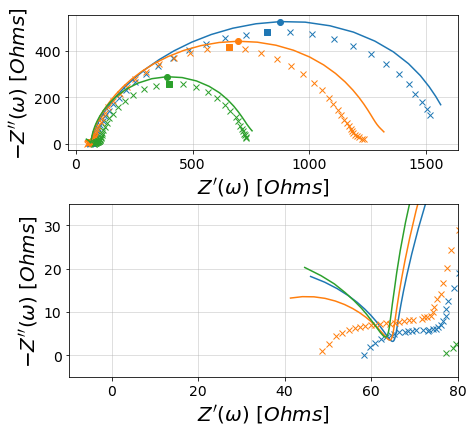

,pO2,ao,xvo,ld,tg,c_chem,ASR,Rg,R_gate,C_gate
0,-2,2.689352,0.020081,0.003280,2.3440,3050.050719,12.159668,3552.736412,26023.516539,0.000090
1,-1,2.088116,0.013104,0.001715,0.9462,2547.283825,5.840587,3264.540328,12499.733913,0.000075
2,0,1.673198,0.007533,0.000498,0.1447,1885.717904,1.244997,2396.854758,2664.480345,0.000056


In [14]:
# Fitting geometry factor to all datasets simultaneously, but with 2 * Rg
_, axes = plt.subplots(nrows=2, figsize=(7, 7))
Zs_branch_b = []

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 2 for _, row in params_df.iterrows()]
for gas, Z_nh  in enumerate(Zs_nh_list):
    Z_branch_b = berthier.predict_branchB(params_df, gas, R_con, fs_nh_list[gas])
    Zs_branch_b.append(Z_branch_b)


fit = minimize(berthier.minimize_geom_factor_all, [6], method='Nelder-Mead',
               args=(Zs_list, Zs_branch_b, Zs_nh_list))
print(f'Fit geometry factor {fit}')

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    Z_meas = Zs_list[gas]# - R_ohm
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, fit.x[0])
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])
params_df

Data peak f: 0.4641589, Model peak f: 0.3593814
Data peak f: 1.258925, Model peak f: 0.7943282
Data peak f: 4.641589, Model peak f: 3.593814


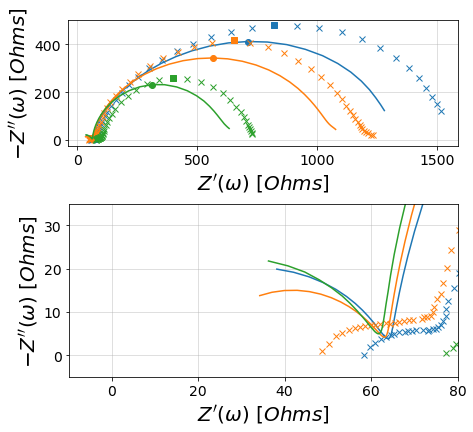

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.359381
1,-1.0,1.258925,0.794328
2,0.0,4.641589,3.593814


In [15]:
# Using estimated geometry factor , but with 2 * Rg
_, axes = plt.subplots(nrows=2, figsize=(7, 7))
Zs_branch_b = []

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 2 for _, row in params_df.iterrows()]
for gas, Z_nh  in enumerate(Zs_nh_list):
    Z_branch_b = berthier.predict_branchB(params_df, gas, R_con, fs_nh_list[gas])
    Zs_branch_b.append(Z_branch_b)

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, Z_branch_b) in enumerate(zip(Zs_nh_list, Zs_branch_b)):
    Z_meas = Zs_list[gas]# - R_ohm
    Z_model = berthier.branchB_and_nh_parallel(Z_branch_b, Z_nh, geom_corr)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
        
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$'])

In [30]:
dums =[] 
# Zs_list_orig = Zs_list
Zs_list = Zs_list_orig

for Z in Zs_list:
    dums.append(Z - R_ohm/2)
    
Zs_list = dums

In [31]:
params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]

r_cons = []
inits = [.5, 4]
for i in np.linspace(2, 3, num=11):
    r_con = R_con/i
    
    fit = minimize(berthier.minimize_2param_scaling, inits, method='Nelder-Mead',
                   args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
    nh_scale = fit.x[0]
    b_scale = fit.x[1]
    print(f'{i}, intial guesses: {inits} R_con: {r_con:.3f} final_res: {fit.fun:.3f} \n\t',
          f'nh_scale: {nh_scale:.3f} n_scale: {b_scale:.3f}')
    r_cons.append([i, fit.fun])

# print('-'*50)

# inits = [4, 0.5]
# for i in np.linspace(2, 3, num=11):
#     r_con = R_con/i
    
#     fit = minimize(berthier.minimize_2param_scaling, inits, method='Nelder-Mead',
#                    args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
#     nh_scale = fit.x[0]
#     b_scale = fit.x[1]
#     print(f'{i}, intial guesses: {inits} R_con: {r_con:.3f} final_res: {fit.fun:.3f} \n\t',
#           f'nh_scale: {nh_scale:.3f} n_scale: {b_scale:.3f}')
#     r_cons.append([i, fit.fun])

# print('-'*50)

# inits = [10, 10]
# for i in np.linspace(2, 3, num=11):
#     r_con = R_con/i
    
#     fit = minimize(berthier.minimize_2param_scaling, inits, method='Nelder-Mead',
#                    args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
#     nh_scale = fit.x[0]
#     b_scale = fit.x[1]
#     print(f'{i}, intial guesses: {inits} R_con: {r_con:.3f} final_res: {fit.fun:.3f} \n\t',
#           f'nh_scale: {nh_scale:.3f} n_scale: {b_scale:.3f}')
#     r_cons.append([i, fit.fun])

# print('-'*50)

2.0, intial guesses: [0.5, 4] R_con: 33.905 final_res: 27.615 
	 nh_scale: 0.755 n_scale: 1.853
2.1, intial guesses: [0.5, 4] R_con: 32.291 final_res: 26.486 
	 nh_scale: 0.735 n_scale: 1.925
2.2, intial guesses: [0.5, 4] R_con: 30.823 final_res: 25.899 
	 nh_scale: 0.719 n_scale: 2.003
2.3, intial guesses: [0.5, 4] R_con: 29.483 final_res: 25.725 
	 nh_scale: 0.705 n_scale: 2.064
2.4, intial guesses: [0.5, 4] R_con: 28.254 final_res: 25.991 
	 nh_scale: 0.693 n_scale: 2.105
2.5, intial guesses: [0.5, 4] R_con: 27.124 final_res: 26.527 
	 nh_scale: 0.683 n_scale: 2.160
2.6, intial guesses: [0.5, 4] R_con: 26.081 final_res: 27.334 
	 nh_scale: 0.675 n_scale: 2.224
2.7, intial guesses: [0.5, 4] R_con: 25.115 final_res: 28.306 
	 nh_scale: 0.665 n_scale: 2.283
2.8, intial guesses: [0.5, 4] R_con: 24.218 final_res: 29.365 
	 nh_scale: 0.661 n_scale: 2.306
2.9, intial guesses: [0.5, 4] R_con: 23.383 final_res: 30.513 
	 nh_scale: 0.658 n_scale: 2.354
3.0, intial guesses: [0.5, 4] R_con: 22.

intial guesses: [0.7, 2.3] R_con: 29.483 final_res: 25.725 
	 nh_scale: 0.705 n_scale: 2.064
Data peak f: 0.4641589, Model peak f: 0.3593814
Data peak f: 1.258925, Model peak f: 1.0
Data peak f: 4.641589, Model peak f: 4.641589


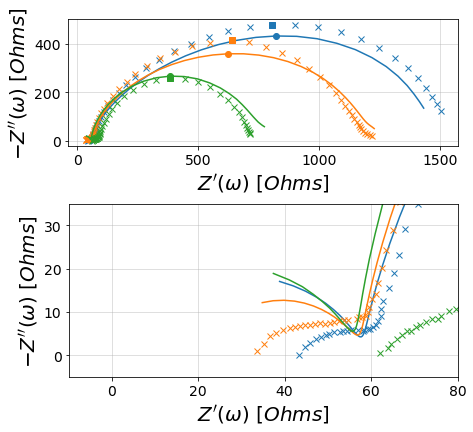

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.359381
1,-1.0,1.258925,1.000000
2,0.0,4.641589,4.641589


,nh_scale,b_scale,$R_c$
0,0.705131,2.06404,29.482732


In [36]:
# Fitting to 2 parameter scaling, with NH sample multiplied by area ratio
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

inits = [.7, 2.3]
r_con = R_con / 2.3

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]
fit = minimize(berthier.minimize_2param_scaling, inits, method='Nelder-Mead',
               args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))

nh_scale = fit.x[0]
b_scale = fit.x[1]
print(f'intial guesses: {inits} R_con: {r_con:.3f} final_res: {fit.fun:.3f} \n\t',
      f'nh_scale: {nh_scale:.3f} n_scale: {b_scale:.3f}')


f_peaks, f_peaks_model = [], []

for gas, (Z_nh, freqs) in enumerate(zip(Zs_nh_list, fs_nh_list)):
    Z_meas = Zs_list[gas]# - R_ohm
    Z_branch_b = berthier.predict_branchB(params_df, gas, r_con, freqs)
    Z_model = berthier.nh_and_b_para_2param_scaling(b_scale, nh_scale, Z_branch_b, Z_nh, A_ratio)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
    
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
display(pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$']))
display(pd.DataFrame(data = np.array([[nh_scale, b_scale, r_con]]), columns=['nh_scale', 'b_scale','$R_c$']))

intial guesses: [0.7, 2.3, 29.482732209989905] R_con: 37.974 final_res: 24.669 
	 nh_scale: 0.749 n_scale: 2.065
Data peak f: 0.4641589, Model peak f: 0.2782559
Data peak f: 1.258925, Model peak f: 0.7943282
Data peak f: 4.641589, Model peak f: 3.593814


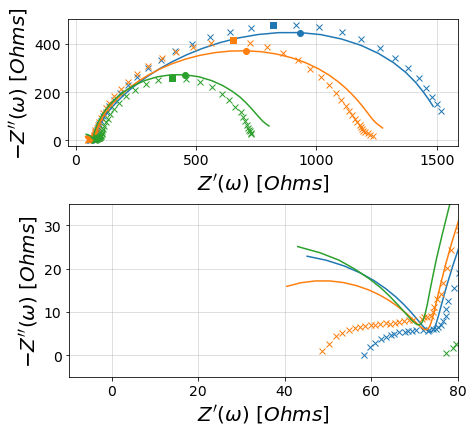

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.278256
1,-1.0,1.258925,0.794328
2,0.0,4.641589,3.593814


,nh_scale,b_scale,$R_c$
0,0.749401,2.064685,37.974135


In [18]:
# Fitting to 2 parameter scaling + r_con, with NH sample multiplied by area ratio
_, axes = plt.subplots(nrows=2, figsize=(7, 7))

inits = [.7, 2.3, R_con / 2.3]

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]
fit = minimize(berthier.minimize_2param_scaling_Rcon, inits, method='Nelder-Mead',
               args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, params_df))

nh_scale = fit.x[0]
b_scale = fit.x[1]
r_con = fit.x[2]
print(f'intial guesses: {inits} R_con: {r_con:.3f} final_res: {fit.fun:.3f} \n\t',
      f'nh_scale: {nh_scale:.3f} n_scale: {b_scale:.3f}')

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, freqs) in enumerate(zip(Zs_nh_list, fs_nh_list)):
    Z_meas = Zs_list[gas]# - R_ohm * 2
    Z_branch_b = berthier.predict_branchB(params_df, gas, r_con, freqs)
    Z_model = berthier.nh_and_b_para_2param_scaling(b_scale, nh_scale, Z_branch_b, Z_nh, A_ratio)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')
    
axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
display(pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$']))
display(pd.DataFrame(data = np.array([[nh_scale, b_scale, r_con]]), columns=['nh_scale', 'b_scale','$R_c$']))

In [19]:
def print_fits(fit, inits):
    print(f'intial guesses: {inits} final_res: {fit.fun:.3f} \n\t',
      f'nh_scale: {fit.x[0]:.3f} tg_scale: {fit.x[1]:.3f} rg_scale: {fit.x[2]:.3f} ')

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]

inits = [.5, 1.5, 2]
r_con = R_con / 1.2
fit = minimize(berthier.minimize_3param_scaling, inits, method='Nelder-Mead',
               args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
print_fits(fit, inits)

# inits = [.1, .1, .1]
# fit = minimize(berthier.minimize_3param_scaling, inits, method='Nelder-Mead',
#                args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
# print_fits(fit, inits)

# inits = [10, 10, 10]
# fit = minimize(berthier.minimize_3param_scaling, inits, method='Nelder-Mead',
#                args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
# print_fits(fit, inits)

# inits = [2, 2, 2] 
# fit = minimize(berthier.minimize_3param_scaling, inits, method='Nelder-Mead',
#                args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
# print_fits(fit, inits)

print('-'*50)
for i in np.linspace(.7, 1.2, num=11):
    r_con = R_con / i
    inits = [.5, 1, 2] 
    fit = minimize(berthier.minimize_3param_scaling, inits, method='Nelder-Mead',
                   args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
    print_fits(fit, inits)
    print(i)

intial guesses: [0.5, 1.5, 2] final_res: 47.128 
	 nh_scale: 5.503 tg_scale: 0.120 rg_scale: 0.811 
--------------------------------------------------
intial guesses: [0.5, 1, 2] final_res: 38.881 
	 nh_scale: 0.880 tg_scale: 0.222 rg_scale: 1.638 
0.7
intial guesses: [0.5, 1, 2] final_res: 35.910 
	 nh_scale: 0.932 tg_scale: 0.212 rg_scale: 1.537 
0.75
intial guesses: [0.5, 1, 2] final_res: 33.710 
	 nh_scale: 1.036 tg_scale: 0.198 rg_scale: 1.387 
0.7999999999999999
intial guesses: [0.5, 1, 2] final_res: 32.369 
	 nh_scale: 1.156 tg_scale: 0.188 rg_scale: 1.279 
0.85
intial guesses: [0.5, 1, 2] final_res: 32.624 
	 nh_scale: 1.500 tg_scale: 0.170 rg_scale: 1.101 
0.8999999999999999
intial guesses: [0.5, 1, 2] final_res: 34.049 
	 nh_scale: 1.704 tg_scale: 0.164 rg_scale: 1.045 
0.95
intial guesses: [0.5, 1, 2] final_res: 36.082 
	 nh_scale: 2.168 tg_scale: 0.149 rg_scale: 0.964 
1.0
intial guesses: [0.5, 1, 2] final_res: 38.612 
	 nh_scale: 2.970 tg_scale: 0.135 rg_scale: 0.888 
1.05

intial guesses: [0.8, 1, 2] final_res: 36.082 
	 nh_scale: 2.168 tg_scale: 0.149 rg_scale: 0.964 
Data peak f: 0.4641589, Model peak f: 0.5994843
Data peak f: 1.258925, Model peak f: 1.258925
Data peak f: 4.641589, Model peak f: 3.593814


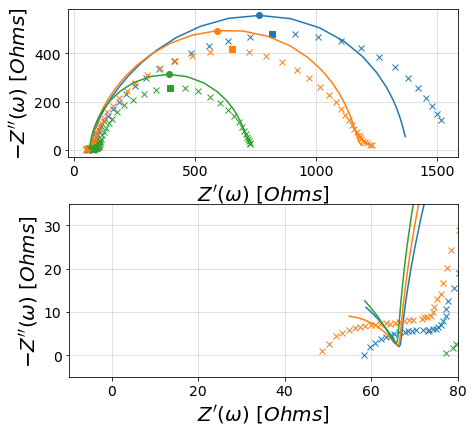

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.599484
1,-1.0,1.258925,1.258925
2,0.0,4.641589,3.593814


,nh_scale,tg_scale,rg_scale,$R_c$
0,2.167699,0.148719,0.963691,67.810284


In [20]:
# Fitting to 3 parameter scaling, with NH sample multiplied by area ratio
_, axes = plt.subplots(nrows=2, figsize=(7, 7))
Zs_branch_b = []

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]

inits = [.8, 1, 2]
r_con = R_con / 1.0
fit = minimize(berthier.minimize_3param_scaling, inits, method='Nelder-Mead',
               args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))
print_fits(fit, inits)

nh_scale = fit.x[0]
tg_scale = fit.x[1]
rg_scale = fit.x[2]

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, freqs) in enumerate(zip(Zs_nh_list, fs_nh_list)):
    Z_meas = Zs_list[gas]# - R_ohm
    Z_branch_b = berthier.predict_branchB_scaled_tg_Rg(params_df, tg_scale, rg_scale, gas, r_con, freqs)
    Z_model =  berthier.nh_and_b_para_2param_scaling(1, nh_scale, Z_branch_b, Z_nh, A_ratio)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')

axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
display(pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$']))
display(pd.DataFrame(data = np.array([[nh_scale, tg_scale, rg_scale, r_con]]), columns=['nh_scale', 'tg_scale', 'rg_scale', '$R_c$']))

intial guesses: [0.5, 1.5, 2, 67.81028408297678] final_res: 32.254 
	 nh_scale: 1.327 tg_scale: 0.177 rg_scale: 1.168 r_con: 78.346
Data peak f: 0.4641589, Model peak f: 0.5994843
Data peak f: 1.258925, Model peak f: 1.258925
Data peak f: 4.641589, Model peak f: 3.593814


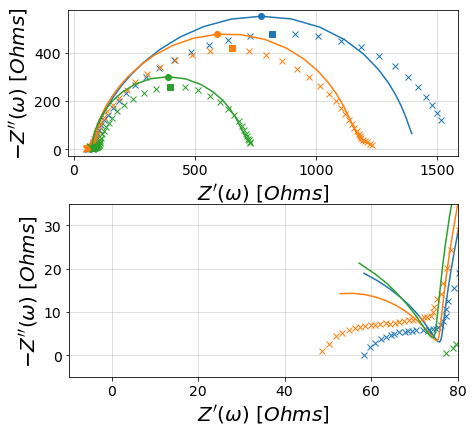

,pO2,$f_p$,"$f_{p,model}$"
0,-2.0,0.464159,0.599484
1,-1.0,1.258925,1.258925
2,0.0,4.641589,3.593814


,nh_scale,tg_scale,rg_scale,$R_c$
0,1.326509,0.176668,1.168395,78.345938


In [21]:
# Fitting to 3 parameter scaling and R_con, with NH sample multiplied by area ratio
_, axes = plt.subplots(nrows=2, figsize=(7, 7))
Zs_branch_b = []

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]

inits = [.5, 1.5, 2, R_con/1.0]
fit = minimize(berthier.minimize_3param_scaling_Rcon, inits, method='Nelder-Mead',
               args=(Zs_list, Zs_nh_list, fs_nh_list, A_ratio, params_df))
print(f'intial guesses: {inits} final_res: {fit.fun:.3f} \n\t',
      f'nh_scale: {fit.x[0]:.3f} tg_scale: {fit.x[1]:.3f} rg_scale: {fit.x[2]:.3f} r_con: {fit.x[3]:.3f}')

nh_scale = fit.x[0]
tg_scale = fit.x[1]
rg_scale = fit.x[2]
r_con = fit.x[3]

f_peaks, f_peaks_model = [], []

for gas, (Z_nh, freqs) in enumerate(zip(Zs_nh_list, fs_nh_list)):
    Z_meas = Zs_list[gas]# - R_ohm
    Z_branch_b = berthier.predict_branchB_scaled_tg_Rg(params_df, tg_scale, rg_scale, gas, r_con, freqs)
    Z_model =  berthier.nh_and_b_para_2param_scaling(1, nh_scale, Z_branch_b, Z_nh, A_ratio)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[gas], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[gas], Z_model)
    f_peaks.append(f_peak)
    f_peaks_model.append(f_peak_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')

    for ax in axes:
        plot_nyquist(ax, Z_meas, fmt='x', label=f'{10**(gas-2):.2f} bar, Measured')
        c = ax.lines[-1].get_color()
        plot_nyquist(ax, Z_model, color=c, marker='', label=f'{10**(gas-2):.2f} bar, Full model')
        # Marking peak frequencies
        plot_nyquist(ax, Z_peak, color=c, marker='s')
        plot_nyquist(ax, Z_peak_model, color=c, marker='o')

axes[1].set_xlim(-10, 80)
axes[1].set_ylim(-5, 35)
plt.show()

gases = [-2, -1, 0]
display(pd.DataFrame(data = np.array([gases, f_peaks, f_peaks_model]).T, columns=['pO2', '$f_p$', '$f_{p,model}$']))
display(pd.DataFrame(data = np.array([[nh_scale, tg_scale, rg_scale, r_con]]), columns=['nh_scale', 'tg_scale', 'rg_scale', '$R_c$']))

# Scratch

## $t_G = \frac{c_o L {x_v}^o}{4 A_o {R_o}^o}$  
## $R_G = \frac{R T}{8 F^2 W} \frac{1}{\sqrt{4 c_o {x_v}^o D_v {R_o}^o L}}$

## $t_{G,2} = 0.3 \, t_{G,1}$
## $\frac{L_2}{{R_{o,2}^o}} = 0.3 \, \frac{L_1}{{R_{o,1}^o}}$
## $\frac{{R_{o,1}^o}}{{R_{o,2}^o}} = 0.3 \, \frac{L_1}{L_2}$

## $R_{G,2} = 2 \, R_{G,1}$
## $\frac{1}{\sqrt{{R_{o,2}}^o L_2}} = \frac{2}{\sqrt{{R_{o,1}}^o L_1}}$
## $\sqrt{\frac{{R_{o,1}}^o L_1}{{R_{o,2}}^o L_2}} = 2$
## $\sqrt{(0.3 \, \frac{L_1}{L_2})\frac{L_1}{L_2}} = 2$
## $\frac{L_1}{L_2} = \frac{2}{\sqrt{0.3}} = 3.7 $
## $ L_2 = \frac{630 \, nm}{3.7} = 170 \, nm ?$

In [22]:
colors = ['k', 'r', 'b']
markers = ['o', 's', '^']
labels = ['0.010 bar', '0.10 bar', '1.0 bar']

ms = 3
mew = 0.6
lw = 0.8
# aspect_ratio = 16 / 9 
figsize = (3.604, 4)
leg_title_fontsize = 8
textsize = 8
borderpad = .2
borderaxespad = .15
columnspacing = .1
handletextpad = .1
labelspacing = .1

2.154435
0.3162278
0.129155


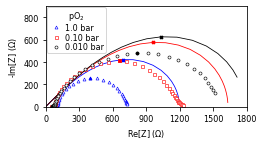

In [23]:
from impedance.models.circuits.elements import G

_, ax = plt.subplots(figsize=figsize)

# Plot Gerischer lines first so they are behind the data
for i, (f, Z) in enumerate(zip(fs_list[::-1], Zs_list[::-1])):
    # reversing order
    i = 2 - i
    rg = params_df.loc[i, 'Rg']
    tg = params_df.loc[i, 'tg']
    zg = G([rg, tg], f)
    f_peak, Z_peak = ic.find_peak_f_Z(f, zg)
    print(f_peak)
    plot_nyquist(ax, zg,
                 c=colors[i],
                 fmt='-',
                 lw=lw)
    plot_nyquist(ax, Z_peak,
                 c=colors[i],
                 fmt='X',
                 ms=ms)
    
    f_peak, Z_peak = ic.find_peak_f_Z(f, Z)
    plot_nyquist(ax, Z,
                 label=labels[i],
                 c=colors[i],
                 fmt=markers[i],
                 mfc=(1,1,1),
                 ms=ms,
                 mew=mew
                 )
    plot_nyquist(ax, Z_peak,
                 c=colors[i],
                 fmt=markers[i],
                 ms=ms,
                 mew=mew)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(300))
ax.tick_params(axis='both', which='major', labelsize=textsize)
ax.grid(False)   
ax.set_xlabel(r'Re[Z] ($\Omega$)', fontsize=textsize)
ax.set_ylabel(r'-Im[Z] ($\Omega$)', fontsize=textsize)

ax.set_xlim(0, 1800)
ax.set_ylim(0, 900)

ax.legend(title='pO$_2$',
          title_fontsize=leg_title_fontsize,
          fontsize=textsize,
          borderpad=borderpad,
          borderaxespad=borderaxespad,
          columnspacing=columnspacing,
          handletextpad=handletextpad,
          labelspacing=labelspacing)
# plt.savefig('Plots/EIS/1D_Zg_MB_20210312.svg', bbox_inches='tight')
plt.show()

In [24]:
Z_dum, Z_dum2 = [], []

for i, Z in enumerate(Zs_list):
    Z_dum.append(Z - Z[0].real)
    Z_dum2.append( Z - R_ohm)

intial guesses: [0.7, 2.3] R_con: 29.483 final_res: 25.725 
	 nh_scale: 0.705 n_scale: 2.064
Data peak f: 4.641589, Model peak f: 4.641589
Data peak f: 1.258925, Model peak f: 1.0
Data peak f: 0.4641589, Model peak f: 0.3593814


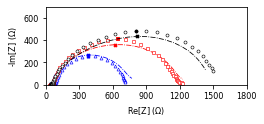

In [25]:
Zs_meas = []

for i, Z in enumerate(Zs_list):
    Zs_meas.append(Z - R_ohm)

# Fitting to 2 parameter scaling, with NH sample multiplied by area ratio
inits = [.7, 2.3]
r_con = R_con / 2.3

params_df['Rg'] = [berthier.Rg(row.ao, row.xvo, row.tg, row.ld, w) * 1 for _, row in params_df.iterrows()]
fit = minimize(berthier.minimize_2param_scaling, inits, method='Nelder-Mead',
               args=(Zs_meas, Zs_nh_list, fs_nh_list, A_ratio, r_con, params_df))

nh_scale = fit.x[0]
b_scale = fit.x[1]
print(f'intial guesses: {inits} R_con: {r_con:.3f} final_res: {fit.fun:.3f} \n\t',
      f'nh_scale: {nh_scale:.3f} n_scale: {b_scale:.3f}')


f_peaks, f_peaks_model = [], []
_, ax = plt.subplots(figsize=figsize)
for i, (Z_nh, freqs) in enumerate(zip(Zs_nh_list[::-1], fs_nh_list[::-1])):
    i = 2 - i 
#     Z_meas = Zs_list[i] - Zs_list[i][0].real
    Z_meas = Zs_meas[i]
    Z_branch_b = berthier.predict_branchB(params_df, i, r_con, freqs)
    Z_model = berthier.nh_and_b_para_2param_scaling(b_scale, nh_scale, Z_branch_b, Z_nh, A_ratio)
    
    f_peak, Z_peak = ic.find_peak_f_Z(fs_list[i], Z_meas)
    f_peak_model, Z_peak_model = ic.find_peak_f_Z(fs_list[i], Z_model)
    print(f'Data peak f: {f_peak}, Model peak f: {f_peak_model}')
    
    # Plot modeled impedance
    plot_nyquist(ax, Z_model,
                 c=colors[i],
                 fmt='-.',
                 lw=lw)
    plot_nyquist(ax, Z_peak_model,
                 c=colors[i],
                 fmt='X',
                 ms=ms)
    
    # Plot measured impedance
    plot_nyquist(ax, Z_meas,
                 label=labels[i],
                 c=colors[i],
                 fmt=markers[i],
                 
                 mfc=(1,1,1),
                 ms=ms,
                 mew=mew
                 )
    plot_nyquist(ax, Z_peak,
                 c=colors[i],
                 fmt=markers[i],
                 ms=ms,
                 mew=mew)

    
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(300))
ax.tick_params(axis='both', which='major', labelsize=textsize)
ax.grid(False)   
ax.set_xlabel(r'Re[Z] ($\Omega$)', fontsize=textsize)
ax.set_ylabel(r'-Im[Z] ($\Omega$)', fontsize=textsize)

ax.set_xlim(0, 1800)
ax.set_ylim(0, 700)

# plt.savefig('Plots/EIS/Modeled_2_param_scaling_20210312.svg', bbox_inches='tight')
plt.show()

## Scratch

In [26]:
def calc_Dv(ld=1, tg=1, Ao=1):
    """Calculate vacancy diffusion coefficient.

    Parameters
    ----------
    ld : float
        Utilization length in microns
    tg : float
        Gerischer time constant in seconds
    Ao : float
        Thermodynamic factor; unitless.

    Returns
    -------
    dv : float
        Diffusion coefficient in units cm^2/s."""

    ld = ld * 1e-4
    dv = ld ** 2 / (Ao * tg)

    return dv


def calc_Roo(tg=1, Ao=1, xvo=.01, L=0.630):
    """Calculate exchange rate coefficient.

    Parameters
    ----------
    tg : float
        Gerischer time constant in seconds
    Ao : float
        Thermodynamic factor; unitless.
    xvo : float
        Vacancy mol fraction
    L : float
        Film thickness in microns.

    Returns
    -------
    roo : float
        Exchange rate coefficient in units mol cm^-2 s^-1."""

    L = L * 1e-4
    co = 3 / 33.7
    roo = co * L * xvo / (4 * tg * Ao)

    return roo

In [27]:
params_df['Dv'] = calc_Dv(params_df.ld, params_df.tg, params_df.ao)
params_df['Roo'] = calc_Roo(params_df.tg, params_df.ao, params_df.xvo)
params_df

,pO2,ao,xvo,ld,tg,c_chem,ASR,Rg,R_gate,C_gate,Dv,Roo
0,-2,2.689352,0.020081,0.003280,2.3440,3050.050719,12.159668,1776.368206,26023.516539,0.000090,1.706746e-14,4.466441e-09
1,-1,2.088116,0.013104,0.001715,0.9462,2547.283825,5.840587,1632.270164,12499.733913,0.000075,1.487949e-14,9.298797e-09
2,0,1.673198,0.007533,0.000498,0.1447,1885.717904,1.244997,1198.427379,2664.480345,0.000056,1.023514e-14,4.362295e-08


In [28]:
630/ 3.7

170.27027027027026

In [29]:
1/(.5 * 4)

0.5

In [30]:
2 / np.sqrt(.3)

3.6514837167011076

In [31]:
com_0_01 = pd.read_csv(filepath_or_buffer='../EIS Data/G-2_14_f-MemasuredEIS_MB_LT_Ohmic_pO2-0_01.csv', skiprows=4)

FileNotFoundError: [Errno 2] No such file or directory: '../EIS Data/G-2_14_f-MemasuredEIS_MB_LT_Ohmic_pO2-0_01.csv'

In [ ]:
com_0_01.drop(labels = ['Ao', 'xvo', 'ld', 'tg', 'C_mask', 'sig_i_mask (S/m)'], axis=1, inplace=True)

In [ ]:
plt_df = com_0_01.loc[:, com_0_01.columns.str.startswith('Plt (K)')].copy()
ohm_df = com_0_01.loc[:, com_0_01.columns.str.startswith('Ohmic')].copy()

In [ ]:
ohm_df['f'] = com_0_01['% f']
plt_df['f'] = com_0_01['% f']

In [ ]:
np.sqrt((2*(2.401*.63)**2))/4.28

In [ ]:
np.sqrt((2*67.254**2)) *.63

In [ ]:
np.sqrt(2*(48.038*.63)**2)/4.28

In [ ]:
np.sqrt(2*67.254**2)/4.28

In [ ]:
(20 - .5)*2

In [ ]:
sig_i_lt = 0.0544
G = 4.28
rs = np.linspace(G/2, 20*G, num=40)
Rohms = np.log(2*rs/G)/sig_i_lt
df= pd.DataFrame(data= rs, columns=['radius'])
df['Rohm'] = Rohms
df['Rohm_diff'] = df.Rohm.diff()
df['R_err'] = df.Rohm_diff / df.Rohm
df['r'] = df.radius/G
df